In [1]:
import pandas as pd
import time
from urllib.parse import urlparse
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from prefixspan import PrefixSpan
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from hdbscan import HDBSCAN

C:\Users\somes\anaconda3\envs\adm\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
start = time.time()

file_info_df = None
logon_info_df = None
device_info_df = None
http_info_df = None

#"""# Pandas code to read in CSV Files"""

# PD with Chunks
extracted_folder_path = "./"
start = time.time()
file_info_df = pd.read_csv(extracted_folder_path + 'DataSets/file_info.csv', chunksize=50000)
logon_info_df = pd.read_csv(extracted_folder_path + 'DataSets/logon_info.csv', chunksize= 50000)
device_info_df = pd.read_csv(extracted_folder_path + 'DataSets/device_info.csv', chunksize= 50000)
http_info_df = pd.read_csv(extracted_folder_path + 'DataSets/http_info.csv', chunksize=100000)

file_info_df = pd.concat([chunk for chunk in file_info_df])
logon_info_df = pd.concat([chunk for chunk in logon_info_df])
device_info_df = pd.concat([chunk for chunk in device_info_df])
http_info_df = pd.concat([chunk for chunk in http_info_df])

end = time.time()

print("Read csv with chunks: ", (end - start), "sec")
print(file_info_df.shape)
print(logon_info_df.shape)
print(device_info_df.shape)
print(http_info_df.shape)

Read csv with chunks:  115.21884202957153 sec
(249999, 6)
(499999, 5)
(249999, 5)
(9999999, 6)


In [5]:
unique_values = http_info_df['user'].unique().tolist()

print(len(unique_values))

extracted_folder_path = "./DataSets/details/"
employees_data = []

for i in range(1, 13):
    employee_number = f'{i:02}'
    file_path = f'{extracted_folder_path}2010-{employee_number}.csv'
    print("File Path", file_path)
    df = pd.read_csv(file_path)
    employees_data.append(df)

combined = pd.concat(employees_data)
combined = combined.drop_duplicates()

# Reset the index
combined = combined.reset_index(drop=True)

# del merged_df
merged_df = pd.merge(combined, http_info_df,left_on='user_id', right_on='user', how='inner')

professions = {}
for index, record in merged_df.iterrows():
  if record['role'] not in professions:
    professions[record['role']] = 1
  else:
    professions[record['role']] += 1
print(professions)

sorted_dict = {k: v for k, v in sorted(professions.items(), key=lambda item: item[1])}
print(sorted_dict)

#"""Our best implementation is creationg chunks of the data set and then using multithreading in order to perform various operations on the code. 2 minutes 7 seconds."""

if isinstance(employees_data[0], pd.DataFrame):
    print("df is a Pandas DataFrame")
else:
    print("df is not a Pandas DataFrame")

1000
File Path ./DataSets/details/2010-01.csv
File Path ./DataSets/details/2010-02.csv
File Path ./DataSets/details/2010-03.csv
File Path ./DataSets/details/2010-04.csv
File Path ./DataSets/details/2010-05.csv
File Path ./DataSets/details/2010-06.csv
File Path ./DataSets/details/2010-07.csv
File Path ./DataSets/details/2010-08.csv
File Path ./DataSets/details/2010-09.csv
File Path ./DataSets/details/2010-10.csv
File Path ./DataSets/details/2010-11.csv
File Path ./DataSets/details/2010-12.csv
{'ComputerProgrammer': 264304, 'Salesman': 2791092, 'SoftwareEngineer': 461811, 'ProductionLineWorker': 208519, 'Mathematician': 343366, 'AdministrativeAssistant': 470534, 'Technician': 525071, 'ITAdmin': 526957, 'ManagementTrainer': 22375, 'ElectricalEngineer': 320106, 'InstructionalCoordinator': 32982, 'AssemblySupervisor': 20050, 'Statistician': 54759, 'TestEngineer': 207315, 'Manager': 404288, 'Scientist': 436789, 'Physicist': 237877, 'Accountant': 16971, 'Attorney': 38729, 'IndustrialEngineer'

In [6]:
indices_to_drop = []
pcsLogOn = set()
count = 0
for index, record in logon_info_df.iterrows():

  if record['activity'] == "Logon" and (record['user'], record['pc']) in pcsLogOn:
      indices_to_drop.append(index)
      count += 1
  elif record['activity'] == "Logon":
      pcsLogOn.add((record['user'], record['pc']))
  elif record['activity'] == "Logoff" and (record['user'], record['pc']) not in pcsLogOn:
      indices_to_drop.append(index)
      count += 1
  elif record['activity'] == "Logoff":
    pcsLogOn.remove((record['user'], record['pc']))
print("Number of duplicated counts: " + str(count))
print(len(set(indices_to_drop)))
#logon_info_df.drop(indices_to_drop, inplace=True)

logon_info_df.drop(indices_to_drop, inplace=True)
logon_info_df.to_csv('cleaned_logon.csv', index=False)
print(logon_info_df.iloc[0])

print(len(employees_data))

Number of duplicated counts: 49728
49728
id          {X1D9-S0ES98JV-5357PWMI}
date             2010-01-02 06:49:00
user                         NGF0157
pc                           PC-6056
activity                       Logon
hour                               6
minute                      0.816667
Name: 0, dtype: object
12


[(2, ['PC-8651', 'PC-3430']), (2, ['PC-8651', 'PC-1609']), (2, ['PC-8651', 'PC-6539']), (2, ['PC-8651', 'PC-9582']), (2, ['PC-8651', 'PC-0164']), (2, ['PC-8651', 'PC-3263']), (2, ['PC-8651', 'PC-2645']), (2, ['PC-8651', 'PC-0246']), (2, ['PC-8651', 'PC-2930']), (2, ['PC-8651', 'PC-5027']), (2, ['PC-8651', 'PC-9822']), (2, ['PC-8651', 'PC-8118']), (2, ['PC-8651', 'PC-1845']), (2, ['PC-4600']), (2, ['PC-7345']), (2, ['PC-2567']), (3, ['PC-2930']), (2, ['PC-9706']), (2, ['PC-5423']), (3, ['PC-3430']), (3, ['PC-2244']), (2, ['PC-2244', 'PC-8651']), (4, ['PC-1609']), (2, ['PC-1609', 'PC-8651']), (2, ['PC-8067']), (2, ['PC-4518']), (3, ['PC-6539']), (2, ['PC-8290']), (3, ['PC-9582']), (4, ['PC-9822']), (2, ['PC-9822', 'PC-8651']), (2, ['PC-0198']), (3, ['PC-0164']), (2, ['PC-2370']), (3, ['PC-3534']), (2, ['PC-3534', 'PC-8651']), (2, ['PC-2139']), (3, ['PC-5027']), (2, ['PC-2164']), (2, ['PC-9353']), (3, ['PC-1005']), (2, ['PC-1005', 'PC-8651']), (2, ['PC-6380']), (3, ['PC-5621']), (2, ['PC-

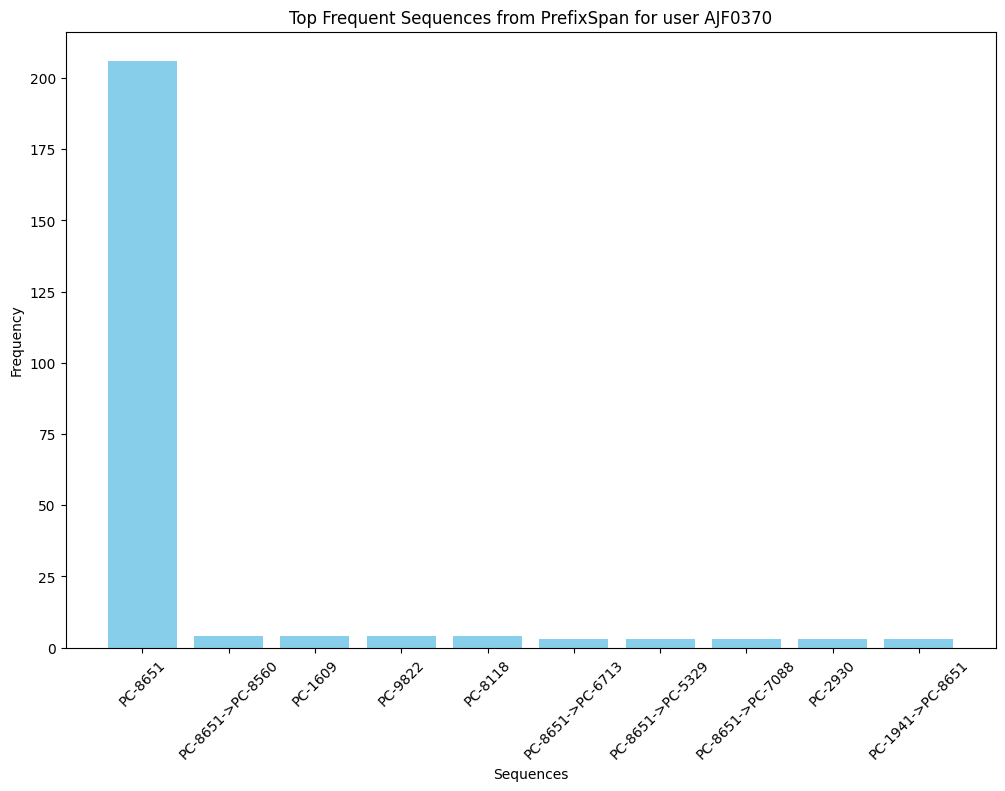

In [7]:

"""# PrefixSpan Implementation"""

'''
THIS IS FOR DEVICE ASSOCIATION MINING
'''

logon_info_df['date'] = pd.to_datetime(logon_info_df['date'], format='%m/%d/%Y %H:%M:%S')

sequences = []
# Show the filtered DataFrame
curr_day = 1
temp_list = []
for index, record in logon_info_df.iterrows():
  if record['date'].day != curr_day:
    curr_day = record['date'].day
    sequences.append(temp_list)
    temp_list = []
  if record['activity'] == "Logon" and record['user'] == "AJF0370":
    temp_list.append(record['pc'])

# NEED TO FIGURE OUT A GOOD PLOT FOR THIS
sequences = [seq for seq in sequences if seq]
ps = PrefixSpan(sequences)
print(ps.frequent(2, closed = True, generator = True))

patterns = ps.frequent(2)

# Assuming you have a list of sequences
ps = PrefixSpan(sequences)
patterns = ps.frequent(1, closed = True, generator = False)  # Adjust minimum support count as needed
patterns.sort(key=lambda x: x[0], reverse=True)  # Sort patterns by frequency

# Extract sequences and their counts
sequence_counts = [(pattern[1], pattern[0]) for pattern in patterns[:10]]  # Get top 10 frequent patterns
sequences, counts = zip(*sequence_counts)

# Convert sequences (which are tuples) to a string format for better visualization
sequence_labels = ['->'.join(seq) for seq in sequences]

plt.figure(figsize=(12, 8))
plt.bar(sequence_labels, counts, color='skyblue')
plt.xlabel('Sequences')
plt.ylabel('Frequency')
plt.title('Top Frequent Sequences from PrefixSpan for user AJF0370')
plt.xticks(rotation=45)  # Rotate the labels for better visibility
plt.show()

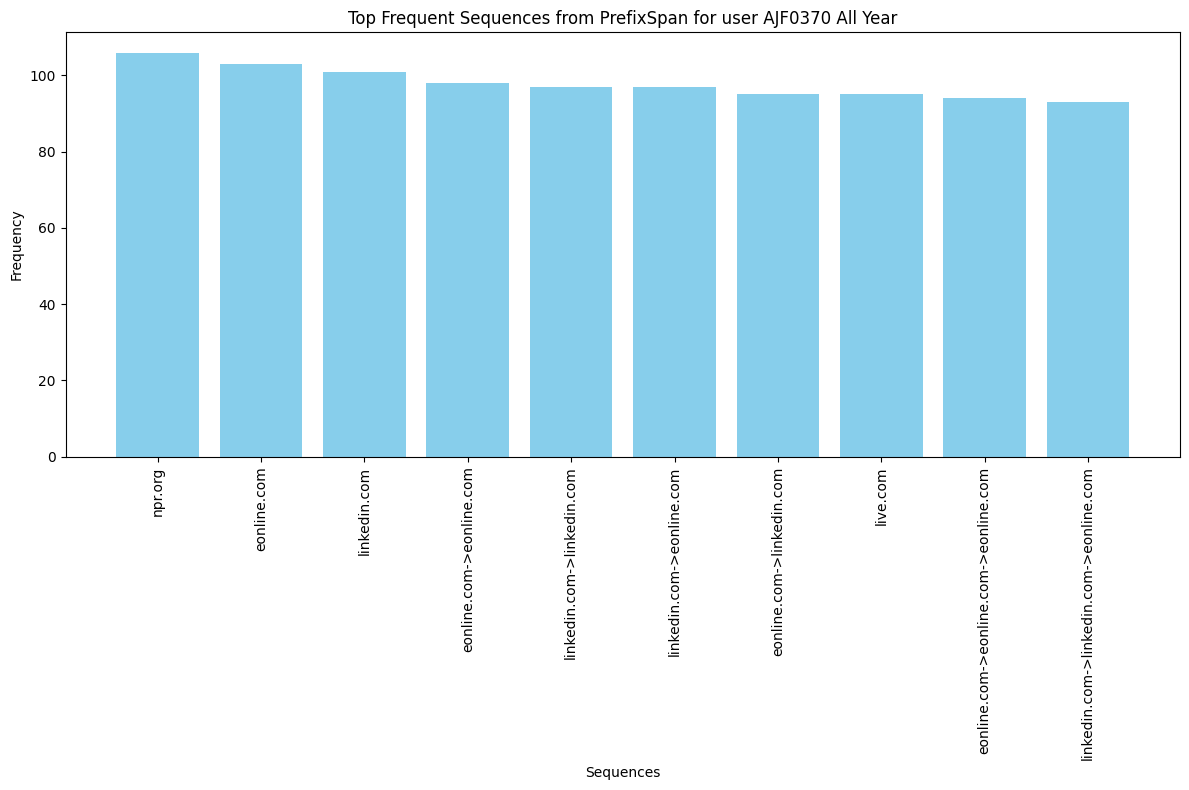

In [8]:
http_info_df['date'] = pd.to_datetime(http_info_df['date'], format='%m/%d/%Y %H:%M:%S')
# Filter DataFrame to select data points in January
sequences = []

curr_day = 1
temp_list = []
# january_data = http_info_df[http_info_df['date'].dt.month == 6]
for index, record in http_info_df.iterrows():
  if record['user'] == "AJF0370":

    if record['date'].day != curr_day:
      curr_day = record['date'].day
      sequences.append(temp_list)
      temp_list = []

    url = record['url']
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    temp_list.append(domain)


# Assuming you have a list of sequences
sequences = [seq for seq in sequences if seq]
ps = PrefixSpan(sequences)
patterns = ps.frequent(35, closed = True, generator = False)  # Adjust minimum support count as needed
patterns.sort(key=lambda x: x[0], reverse=True)  # Sort patterns by frequency

# Extract sequences and their counts
sequence_counts = [(pattern[1], pattern[0]) for pattern in patterns[:10]]  # Get top 10 frequent patterns
sequences, counts = zip(*sequence_counts)

# Convert sequences (which are tuples) to a string format for better visualization
sequence_labels = ['->'.join(seq) for seq in sequences]

plt.figure(figsize=(12, 8))
plt.bar(sequence_labels, counts, color='skyblue')
plt.xlabel('Sequences')
plt.ylabel('Frequency')
plt.title('Top Frequent Sequences from PrefixSpan for user AJF0370 All Year')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0          True
1          True
2          True
3          True
4          True
          ...  
499994    False
499995    False
499996    False
499997    False
499998    False
Name: date, Length: 450271, dtype: bool
2010-10-01 01:43:45
2010-10-01 02:17:12
2010-10-01 04:01:16
2010-10-01 05:08:00
2010-10-01 07:59:40


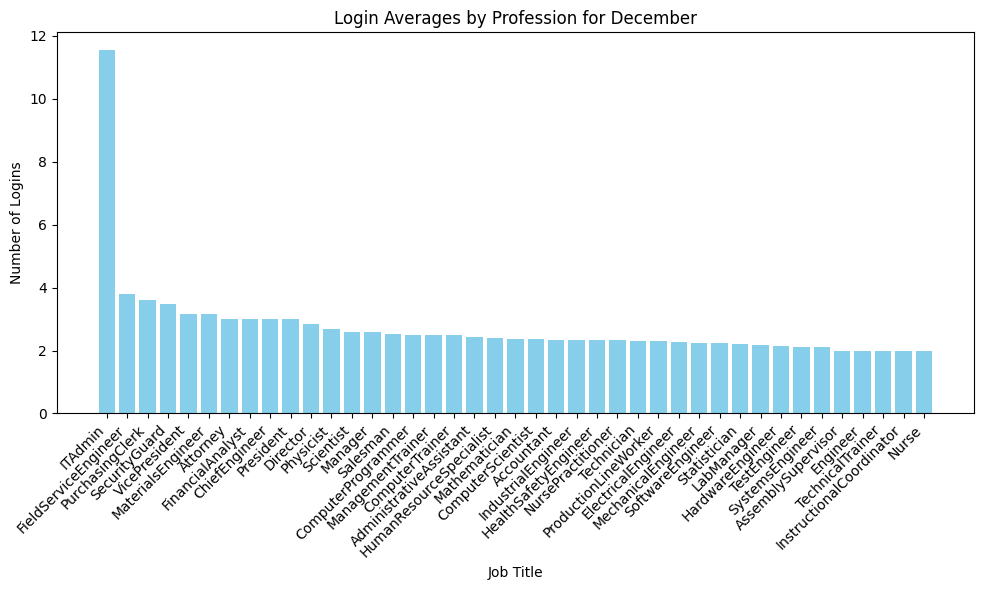

In [32]:
"""# Code to calculate logon logoff counts in total
This code block is to calculate
"""

logon_info_df['date'] = pd.to_datetime(logon_info_df['date'], format='%m/%d/%Y %H:%M:%S')

# Filter DataFrame to select data points in January
february_data = logon_info_df[logon_info_df['date'].dt.month == 10]

print(logon_info_df['date'].dt.month == 1)

# Show the filtered DataFrame
# print(february_data.head(5))
merged_df = pd.merge(february_data, employees_data[11],left_on='user', right_on='user_id', how='inner')

# Calculate the Logging Counts
unique_users = merged_df['user'].unique()
unique_users_list = unique_users.tolist()
loggingCount = {}
for person in unique_users_list:
  loggingCount[person] = 0
# print("List of unique users:", len(unique_users_list))

pairsSet = set()
for index, record in merged_df.iterrows():
  if record['activity'] == "Logon":
    pairsSet.add((record['user'], record['pc']))
  elif record['activity'] == "Logoff":
    if (record['user'], record['pc']) not in pairsSet:
      print(record['date'])
    else:
      pairsSet.remove((record['user'], record['pc']))
      loggingCount[record['user']] += 1
        
        
# Sort the Dictionary
# print(loggingCount)
sorted_logging_count = dict(sorted(loggingCount.items(), key=lambda item: item[1], reverse=True))

# Print the sorted dictionary
# print("Sorted logging count (descending):", sorted_logging_count)

# Calculate the average Counts
professionCounts = {}
nums = {}
for index, record in employees_data[0].iterrows():
  if record['user_id'] in sorted_logging_count:
    if record['role'] not in professionCounts:
      professionCounts[record['role']] = sorted_logging_count[record['user_id']]
      nums[record['role']] = 1
    else:
      professionCounts[record['role']] += sorted_logging_count[record['user_id']]
      nums[record['role']] += 1

average_counts = {}

# Iterate over the keys in the ProfessionCounts dictionary
for profession, count in professionCounts.items():
    # Check if the profession exists in the nums dictionary
    if profession in nums:
        # Calculate the average count by dividing the total count by the number of occurrences
        average_count = count / nums[profession]
        # Store the average count in the average_counts dictionary
        average_counts[profession] = average_count


average_counts = sorted(average_counts.items(), key=lambda x: x[1], reverse=True)
labels = [item[0] for item in average_counts]
values = [item[1] for item in average_counts]

# Create a bar plot of the results
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Job Title')
plt.ylabel('Number of Logins')
plt.title('Login Averages by Profession for December')
plt.tight_layout()
plt.show()


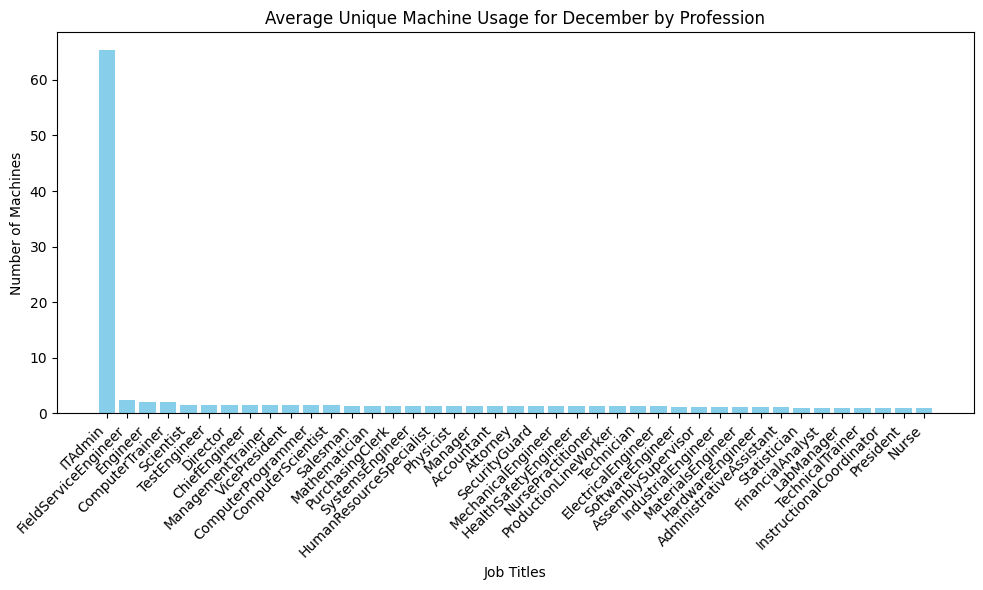

In [47]:
"""# Affinity for Different Devices"""

logon_info_df['date'] = pd.to_datetime(logon_info_df['date'], format='%m/%d/%Y %H:%M:%S')

# Filter DataFrame to select data points in January
january_data = logon_info_df[logon_info_df['date'].dt.month == 6]

# Show the filtered DataFrame
# print(january_data.head(5))
merged_df = pd.merge(january_data, employees_data[11],left_on='user', right_on='user_id', how='inner')
# Calculate the Logging Counts
unique_users = merged_df['user'].unique()
unique_users_list = unique_users.tolist()
devices = {}
for person in unique_users_list:
  devices[person] = set()
# print("List of unique users:", len(unique_users_list))

pairsSet = set()
for index, record in merged_df.iterrows():
  if record['activity'] == "Logon":
    devices[record['user']].add(record['pc'])

# print(devices)
uniqueDeviceCount = {}
userList = devices.keys()
for device in devices:
  uniqueDeviceCount[device] = len(devices[device])
# print(uniqueDeviceCount)
sorted_device = dict(sorted(uniqueDeviceCount.items(), key=lambda item: item[1], reverse=True))

# Print the sorted dictionary
# print("Sorted logging count (descending):", sorted_device)

professionCounts = {}
nums = {}
for index, record in employees_data[0].iterrows():
  if record['user_id'] in sorted_device:
    if record['role'] not in professionCounts:
      professionCounts[record['role']] = sorted_device[record['user_id']]
      nums[record['role']] = 1
    else:
      professionCounts[record['role']] += sorted_device[record['user_id']]
      nums[record['role']] += 1

average_counts = {}

# Iterate over the keys in the ProfessionCounts dictionary
for profession, count in professionCounts.items():
    # Check if the profession exists in the nums dictionary
    if profession in nums:
        # Calculate the average count by dividing the total count by the number of occurrences
        average_count = count / nums[profession]
        # Store the average count in the average_counts dictionary
        average_counts[profession] = average_count


average_counts = sorted(average_counts.items(), key=lambda x: x[1], reverse=True)
labels = [item[0] for item in average_counts]
values = [item[1] for item in average_counts]

# Create a bar plot of the results
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Job Titles')
plt.ylabel('Number of Machines')
plt.title('Average Unique Machine Usage for December by Profession')
plt.tight_layout()
plt.show()

                         id                date     user       pc activity  \
0  {X1D9-S0ES98JV-5357PWMI} 2010-01-02 06:49:00  NGF0157  PC-6056    Logon   
1  {G2B3-L6EJ61GT-2222RKSO} 2010-01-02 06:50:00  LRR0148  PC-4275    Logon   
2  {U6Q3-U0WE70UA-3770UREL} 2010-01-02 06:53:04  LRR0148  PC-4124    Logon   
3  {I0N5-R7NA26TG-6263KNGM} 2010-01-02 07:00:00  IRM0931  PC-7188    Logon   
4  {D1S0-N6FH62BT-5398KANK} 2010-01-02 07:00:00  MOH0273  PC-6699    Logon   

   hour    minute  
0     6  0.816667  
1     6  0.833333  
2     6  0.883333  
3     7  0.000000  
4     7  0.000000  
                             id                date     user       pc  \
53857  {U8X7-K1CK37VD-3665KPJH} 2010-02-01 00:16:44  JAJ0849  PC-9819   
53858  {C7N6-V4AM68PA-0198XLPJ} 2010-02-01 00:19:22  WPR0368  PC-1736   
53859  {N5T2-A5GH70NL-9080NTAQ} 2010-02-01 00:22:13  MPM0220  PC-3842   
53860  {Q8B7-G5FX64RW-5115CDNH} 2010-02-01 00:23:19  WDD0366  PC-6380   
53861  {V1F2-A4ZC92WX-8108TBPM} 2010-02-01 00:

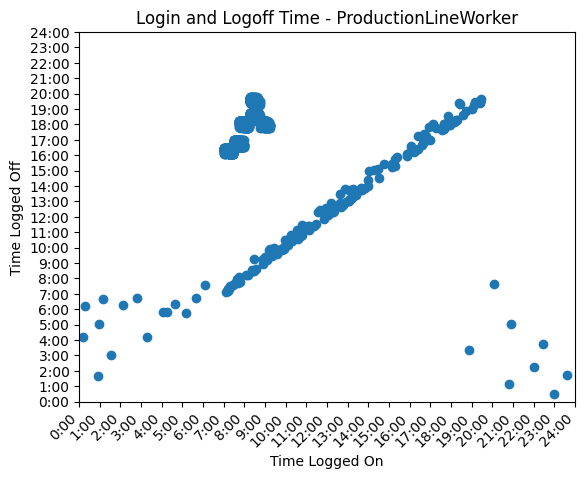

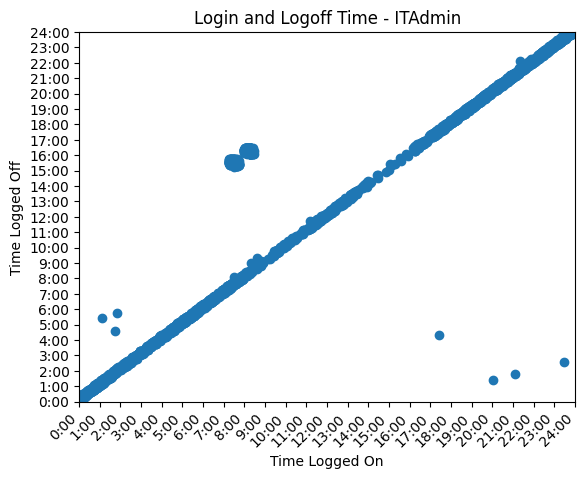

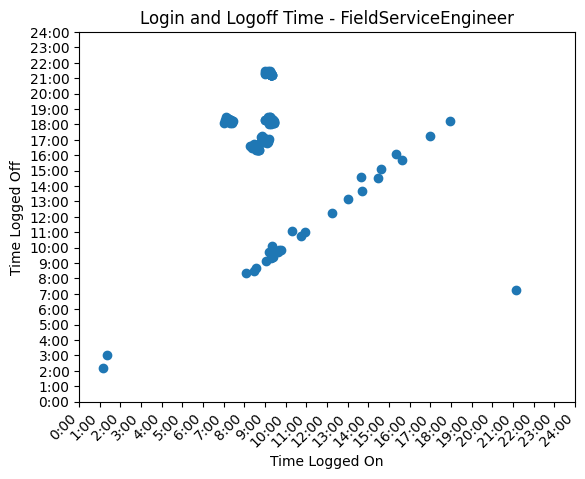

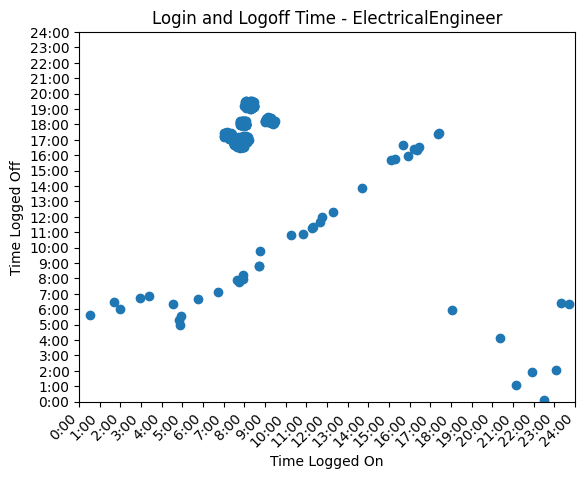

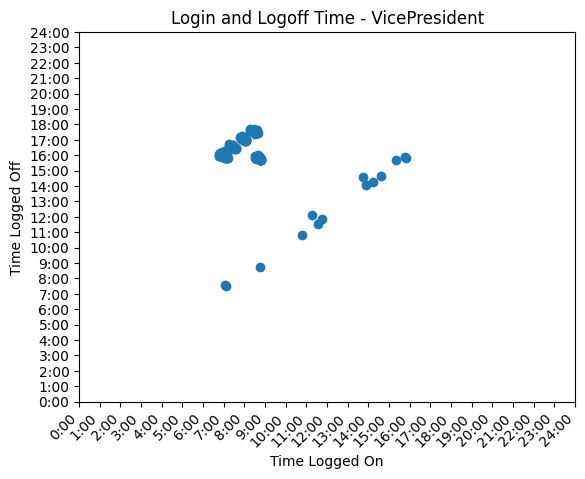

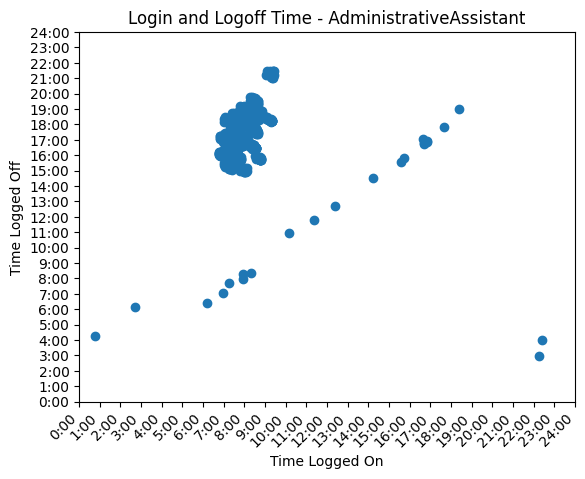

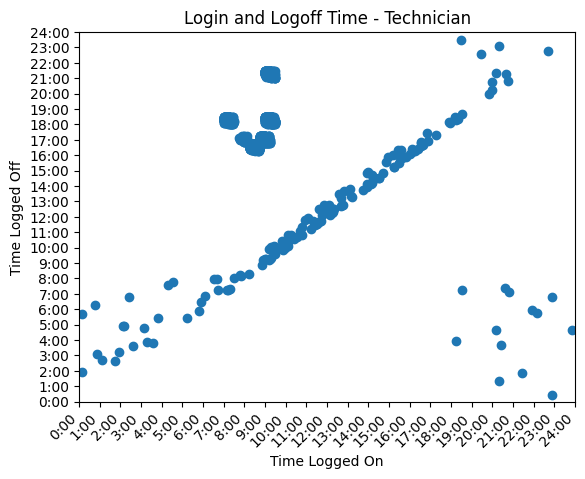

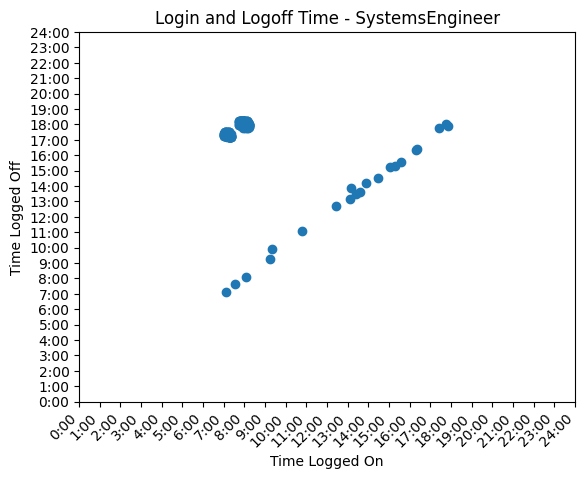

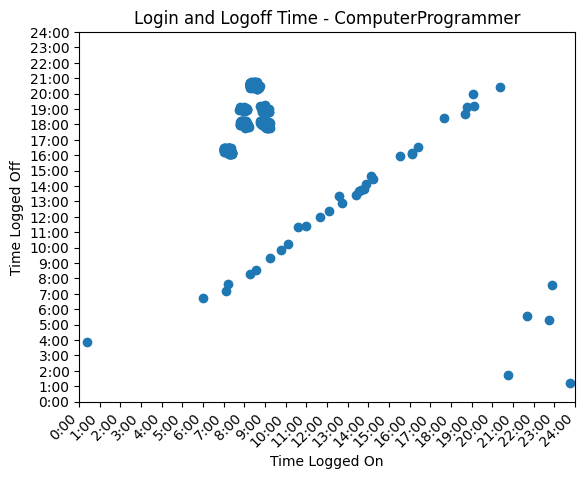

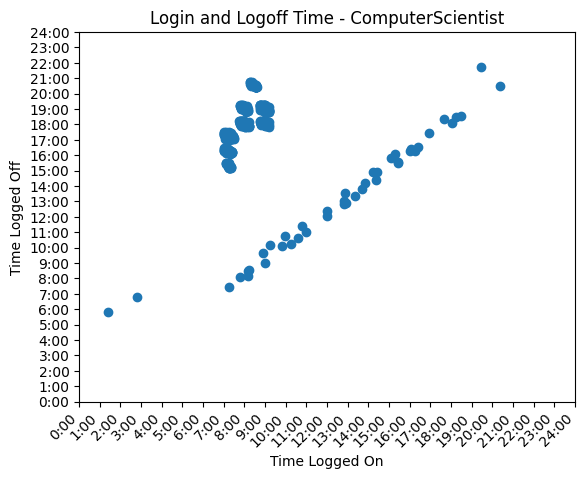

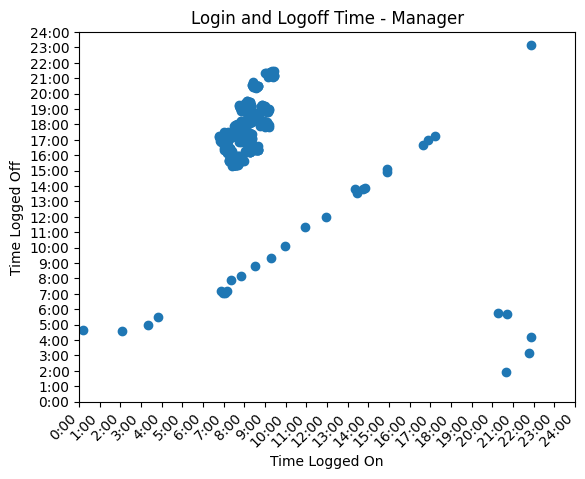

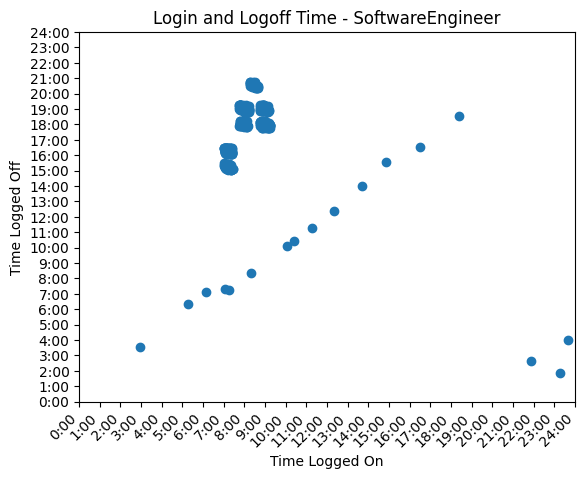

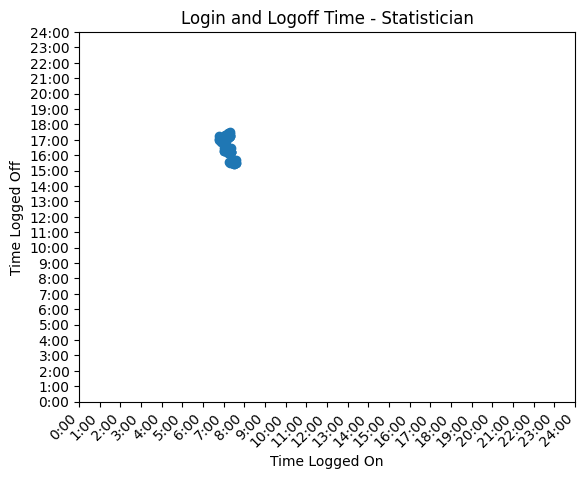

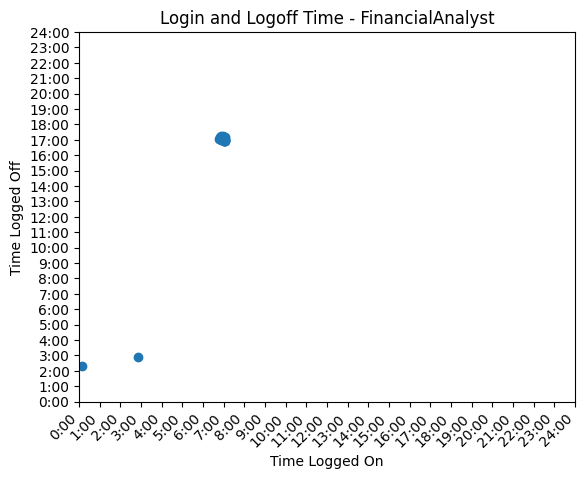

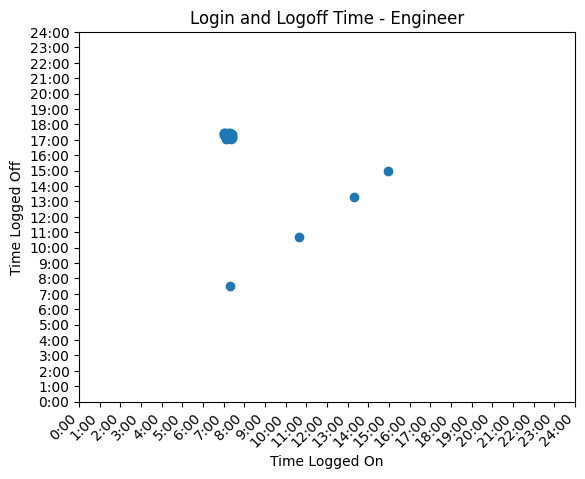

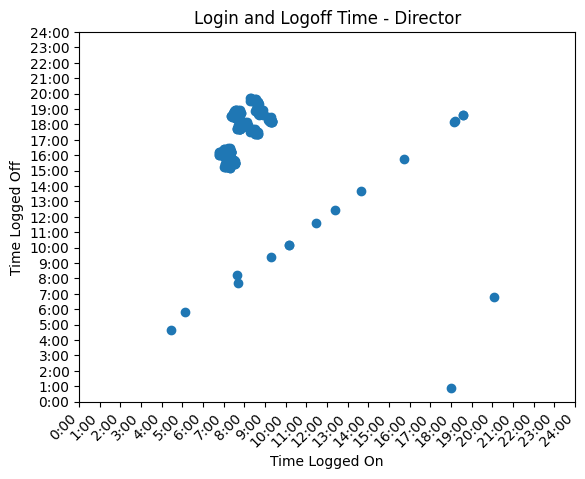

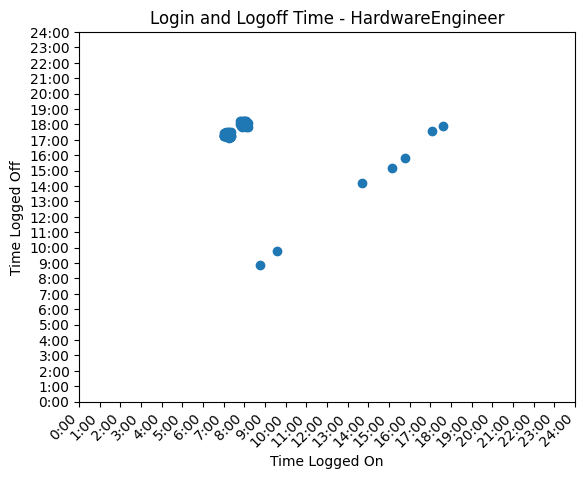

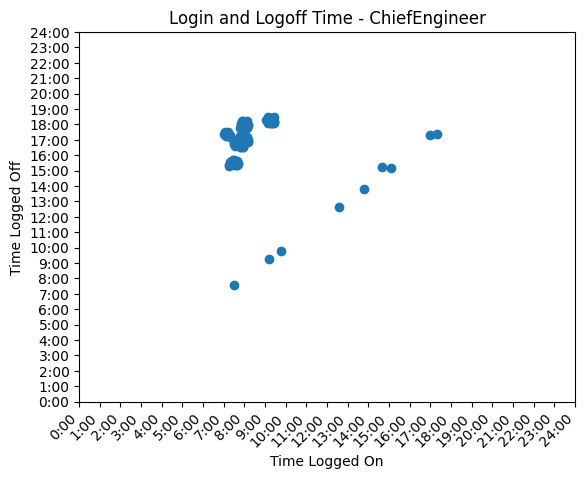

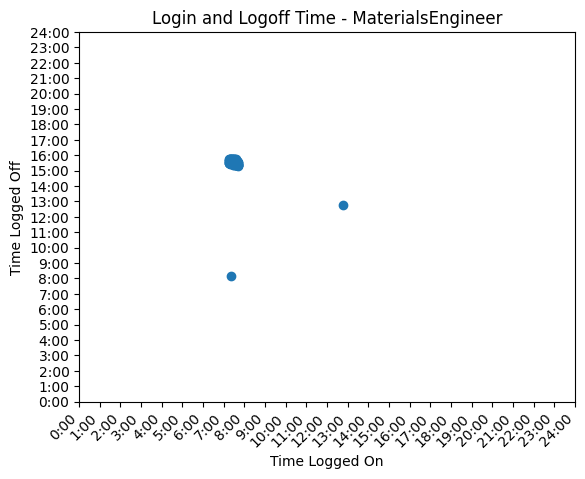

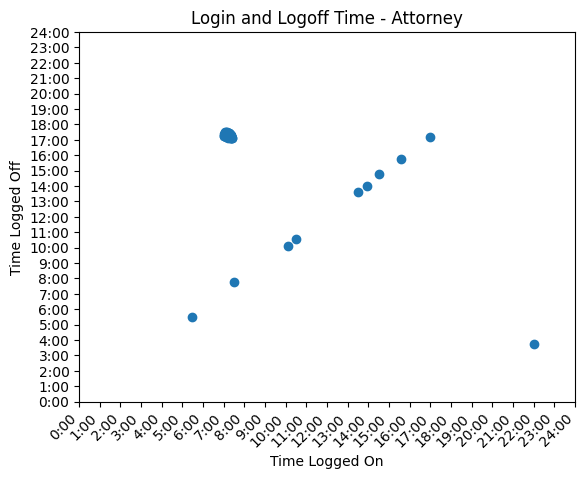

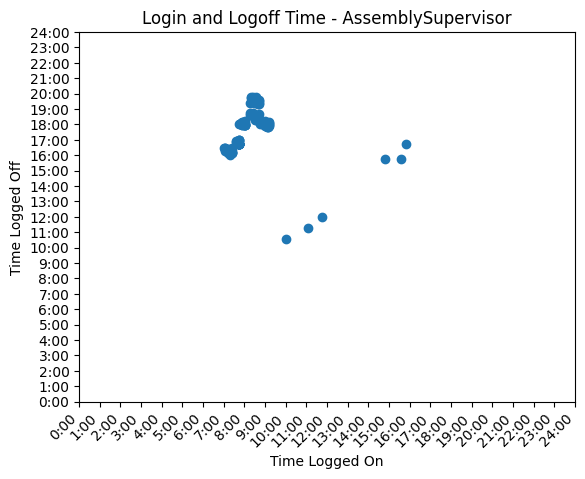

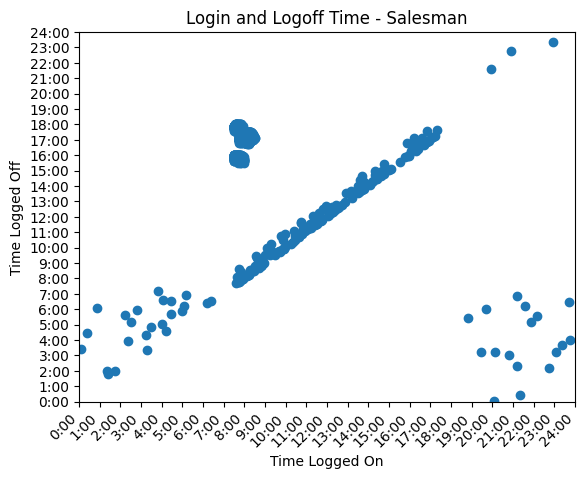

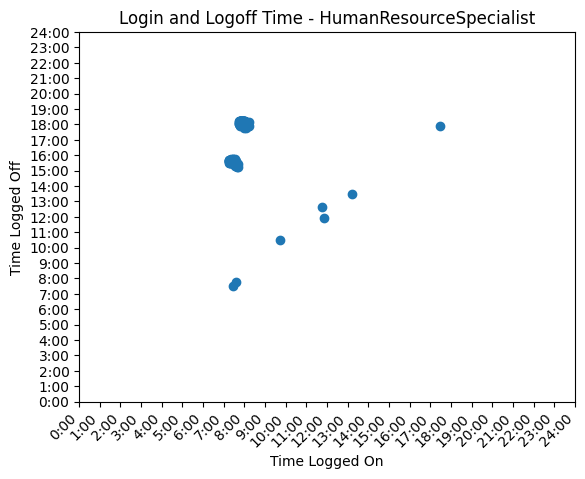

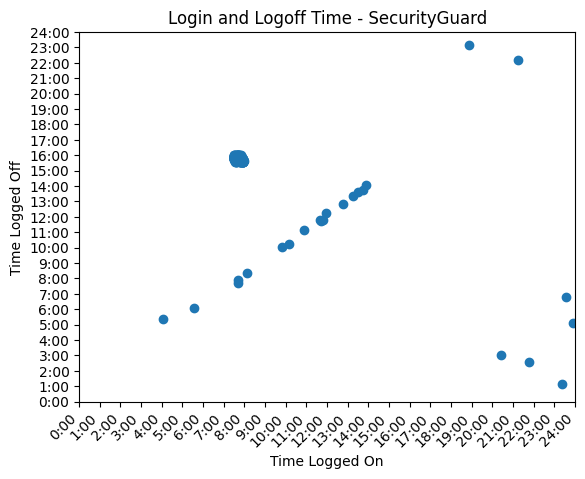

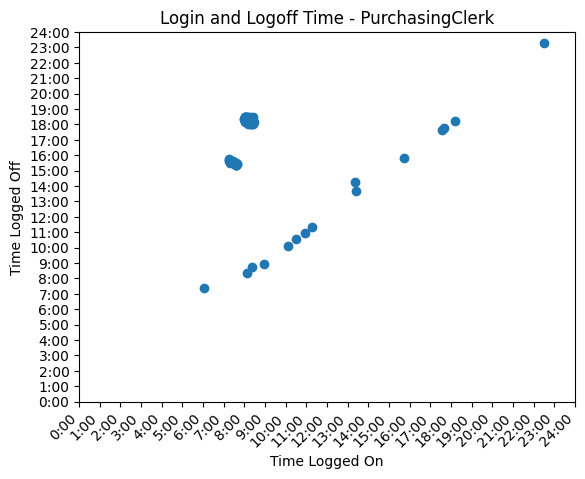

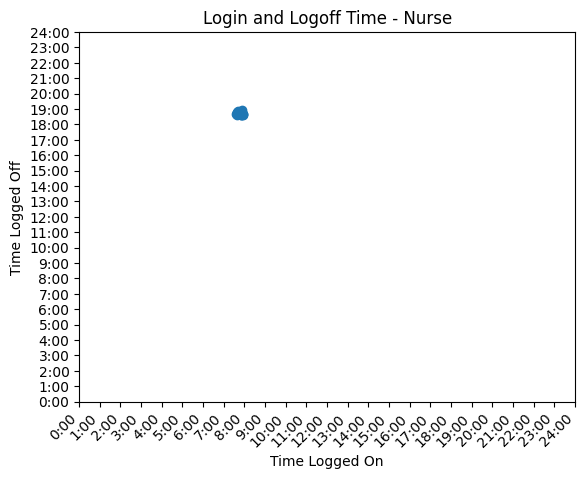

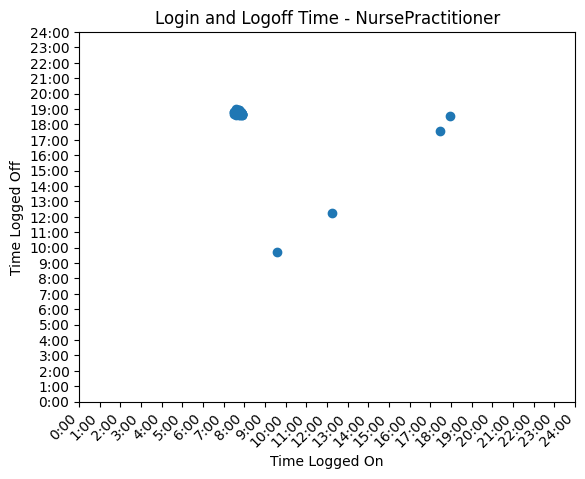

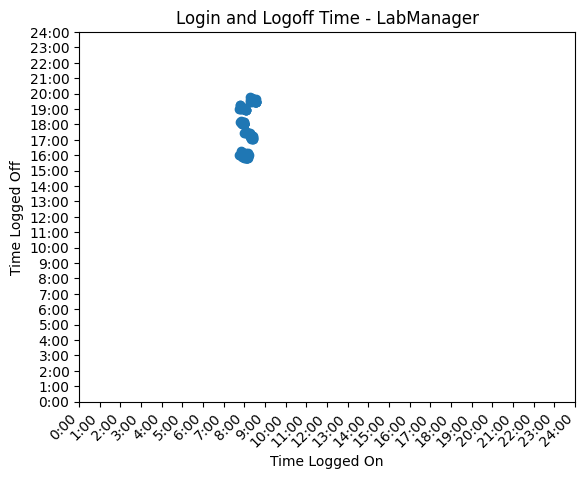

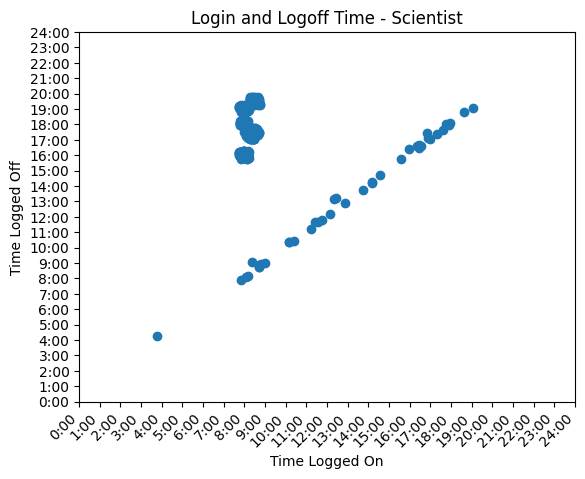

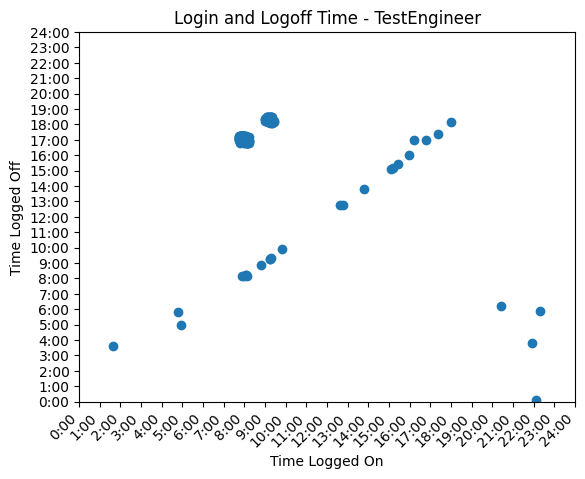

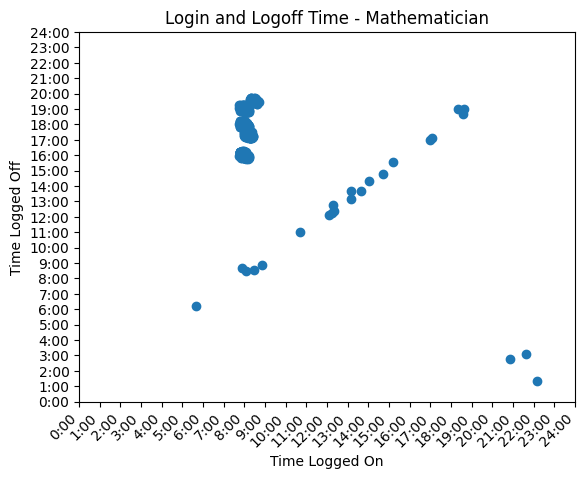

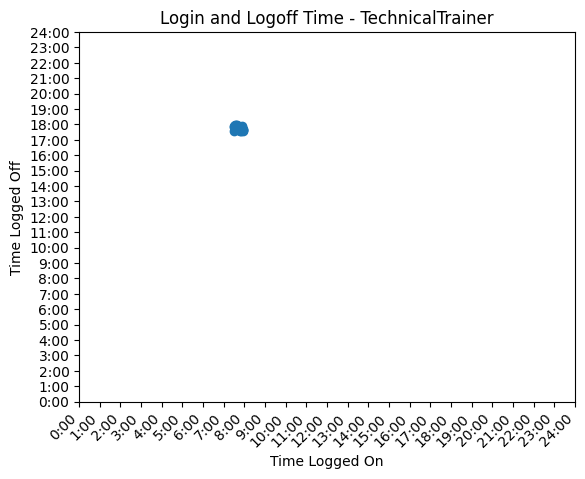

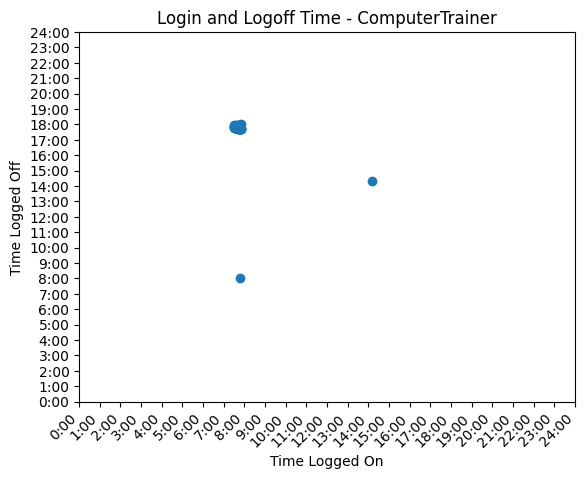

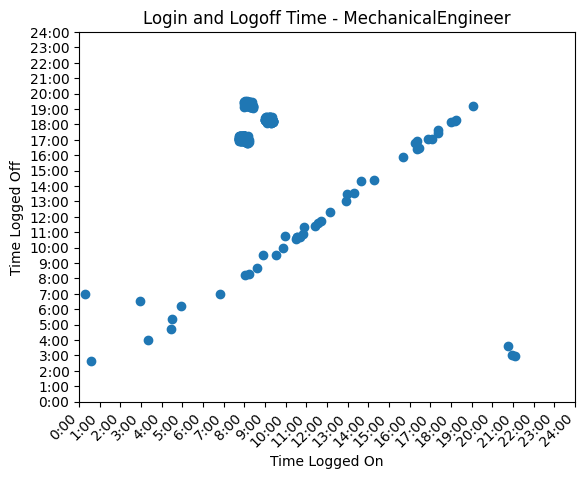

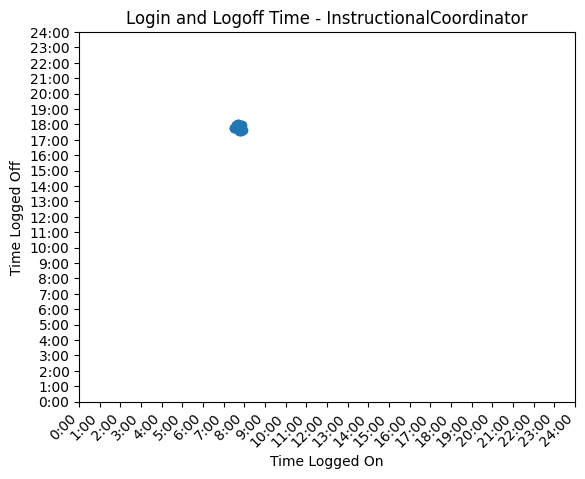

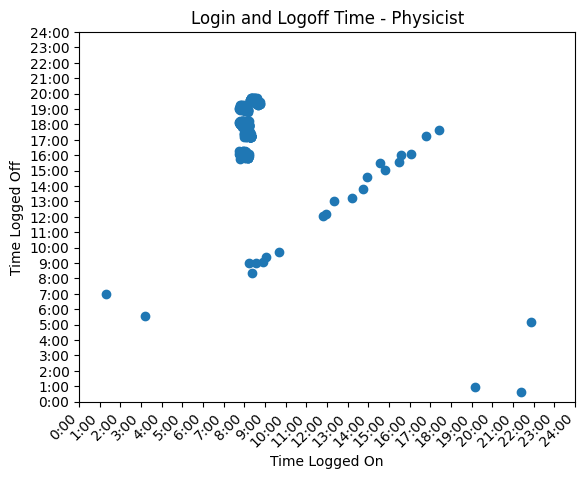

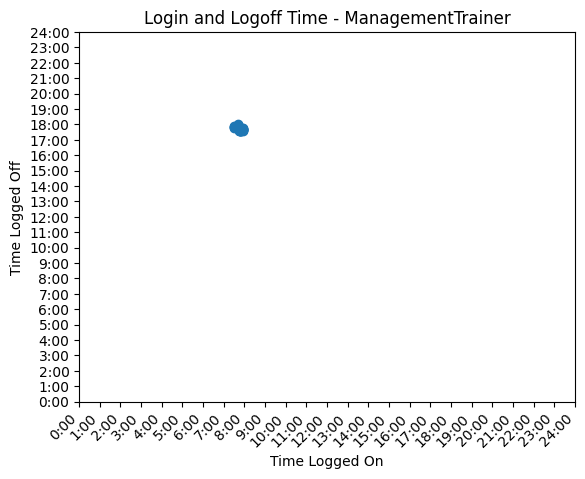

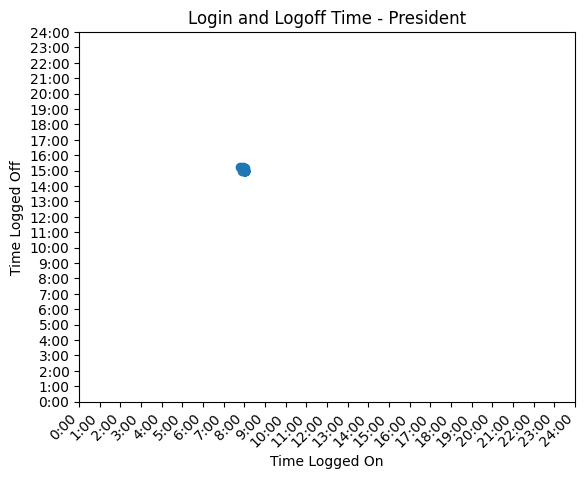

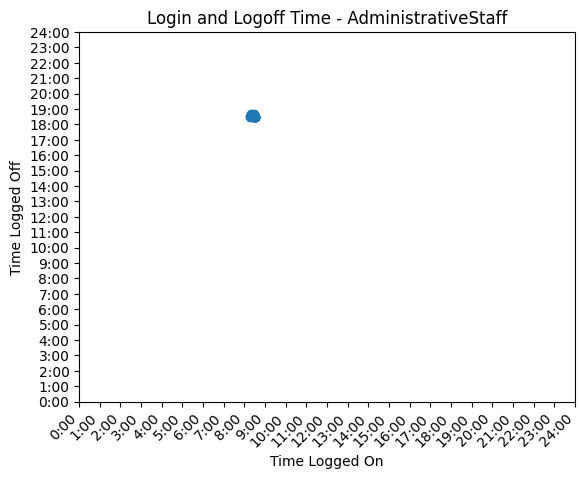

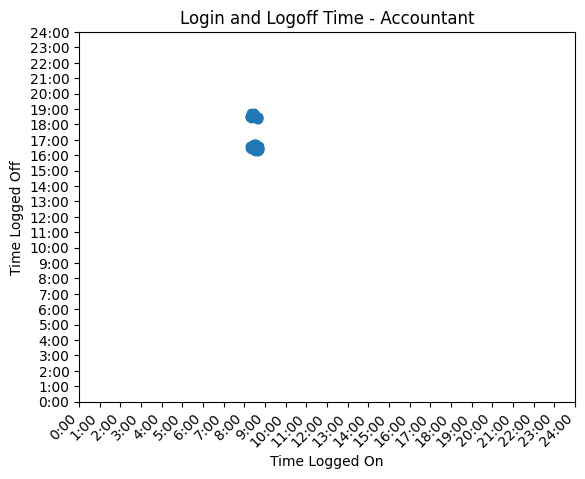

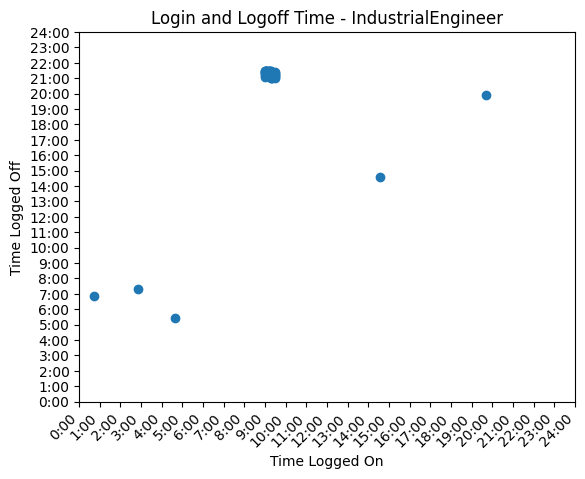

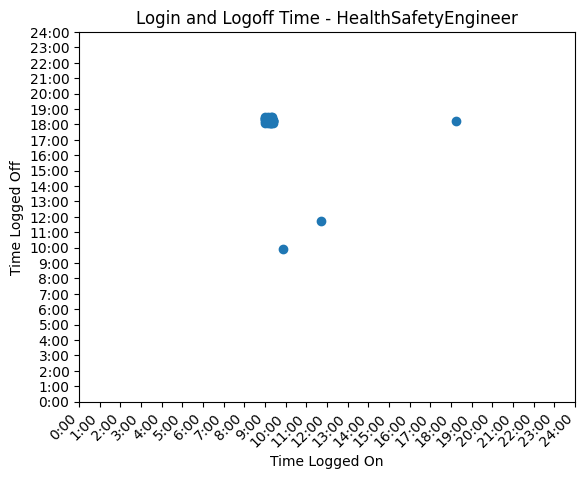

Aggregated data covers months: [1 2 3 4 5 6 7 8 9]
Aggregated data covers users: 246


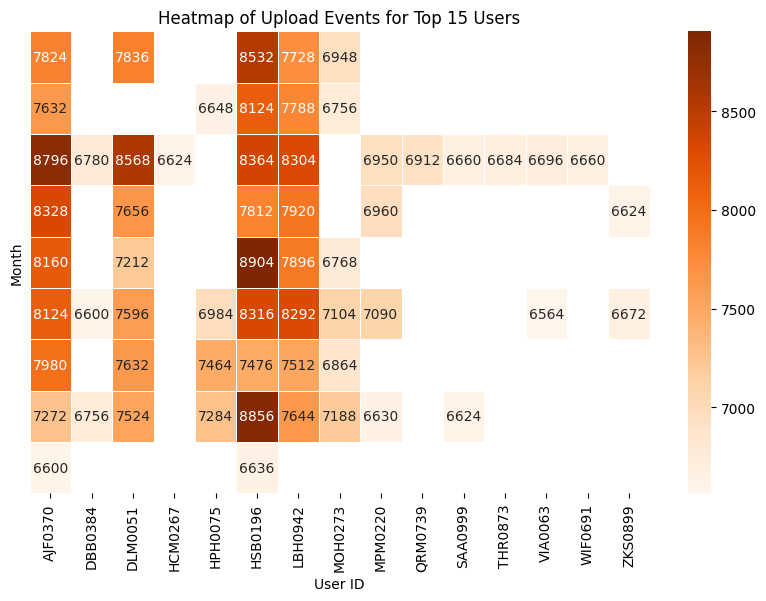

In [48]:
"""# Recording Log On and Log Off Times
This can help us gain some insight into the nature of each person's work. For example, points that lie on a linear line (e.g. where x=12 and y=12 too) we can assume that the nature of their work is quite short not intensive. Things that lie above this linear or even below reflect the fact that the work entails long hours. A lot of the IT admin's work lies on this straight line. IT Admin's work is quick and not too intensive perhaps.
"""

logon_info_df['date'] = pd.to_datetime(logon_info_df['date'], format='%m/%d/%Y %H:%M:%S')

# Create new columns for hour and minute
logon_info_df['hour'] = logon_info_df['date'].dt.hour
logon_info_df['minute'] = logon_info_df['date'].dt.minute/60
print(logon_info_df.head(5))
february_data = logon_info_df[logon_info_df['date'].dt.month == 2]

# Show the filtered DataFrame
print(february_data.head(5))
merged_df = pd.merge(february_data, employees_data[1],left_on='user', right_on='user_id', how='inner')
unique_roles = merged_df['role'].unique()
unique_roles_list = unique_roles.tolist()
loggingTime = {}
for role in unique_roles_list:
  loggingTime[role] = []
print("List of unique users:", len(unique_roles_list))
print(unique_users_list[1])
pairsSet = {}
for index, record in merged_df.iterrows():
  if record['activity'] == "Logon":
    pairsSet[(record['user'], record['pc'])] = [record['hour'] + record['minute'], 0]
  elif record['activity'] == "Logoff":
    #print(index, record['date'])
    if (record['user'], record['pc']) not in pairsSet:
      print(record['date'])
    res = pairsSet.pop((record['user'], record['pc']))
    res[1] = record['hour'] + record['minute']
    loggingTime[record['role']].append(res)

# Create a scatter plot for each profession
for profession, points in loggingTime.items():
  if len(loggingTime[profession]) >= 15:
    # Create a new figure for each profession
    plt.figure()

    # Extract x and y coordinates
    x = [point[0] for point in points]
    y = [point[1] for point in points]

    hours = range(0, 25)  # Assuming time range is from 0:00 to 24:00
    plt.xticks(hours, [f'{h}:00' for h in hours], rotation=45, ha='right')
    plt.yticks(hours, [f'{h}:00' for h in hours])
    plt.xticks(rotation=45, ha='right')
    # Set limits for x and y axes
    plt.xlim(0, 24)
    plt.ylim(0, 24)

    # Plot the points
    plt.scatter(x, y)
    # Add labels and title
    plt.xlabel('Time Logged On')
    plt.ylabel('Time Logged Off')
    plt.title(f'Login and Logoff Time - {profession}')

    # Show the plot
    plt.show()

merged_dfs = []  # This list will hold all the merged DataFrames

# Ensure the 'date' column is in datetime format
file_info_df['date'] = pd.to_datetime(file_info_df['date'])

for emp_data in employees_data:
    # Merge file_info_df with the employees_data DataFrame
    merged_df = pd.merge(file_info_df, emp_data, left_on='user', right_on='user_id', how='inner')

    # Extract the month from the 'date' column and create a new 'Month' column
    merged_df['Month'] = merged_df['date'].dt.month

    # Append the result to the list of merged DataFrames
    merged_dfs.append(merged_df)

# Concatenate all merged DataFrames into a single DataFrame
final_merged_df = pd.concat(merged_dfs, ignore_index=True)

upload_counts = final_merged_df.groupby(['user', 'Month']).size().reset_index(name='counts')

# Recheck the range of months and users in the aggregated data
print("Aggregated data covers months:", upload_counts['Month'].unique())
print("Aggregated data covers users:", upload_counts['user'].nunique())

# Group by 'user' and 'Month' and count the uploads
upload_counts = final_merged_df.groupby(['user', 'Month']).size().reset_index(name='counts')

# Sort the users by the number of uploads and select the top 10
top_users = upload_counts.sort_values('counts', ascending=False).head(60)

# Pivoting the data to create a format suitable for a heatmap
pivot_uploads = top_users.pivot(index='Month', columns='user', values='counts')

# Now, create the heatmap for the pivot table
plt.figure(figsize=(10, 6))  # Adjusting the size of the heatmap as needed
sns.heatmap(pivot_uploads, annot=True, fmt=".0f", cmap='Oranges', linewidths=.5)
plt.title('Heatmap of Upload Events for Top 15 Users')
plt.xlabel('User ID')
plt.yticks([])  # Hides the y-axis ticks as they don't represent 'Month' in this specific setup
plt.show()

Button(description='Click Me!', style=ButtonStyle())

Output()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\somes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\somes\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\somes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 0: 0.002*"long" + 0.002*"although" + 0.002*"away" + 0.002*"three" + 0.002*"time" + 0.002*"two" + 0.002*"much" + 0.002*"received" + 0.002*"however" + 0.002*"also"
Topic 1: 0.002*"also" + 0.002*"second" + 0.002*"may" + 0.002*"time" + 0.002*"made" + 0.002*"although" + 0.002*"line" + 0.002*"early" + 0.002*"began" + 0.002*"th"
Topic 2: 0.002*"first" + 0.002*"made" + 0.002*"well" + 0.002*"also" + 0.002*"within" + 0.002*"three" + 0.002*"considered" + 0.002*"able" + 0.002*"since" + 0.002*"however"
Topic 3: 0.005*"th" + 0.002*"late" + 0.002*"east" + 0.002*"left" + 0.002*"early" + 0.001*"another" + 0.001*"long" + 0.001*"following" + 0.001*"later" + 0.001*"four"
9025
Topic distribution for document 1: [(0, 0.15306447), (2, 0.036621924), (3, 0.8054631)]
Top 10 keys with highest values:


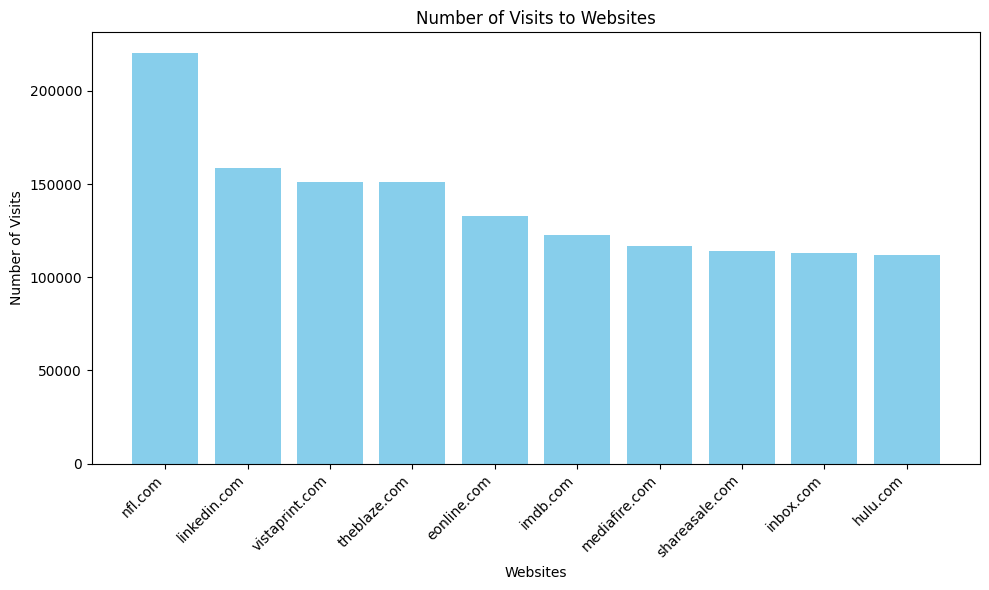

In [50]:
# This code is to impute missing values with the mode
for i, df in enumerate(employees_data):
    for column in df.columns:
        mode_value = df[column].mode()[0]
        df[column].fillna(mode_value, inplace=True)
    employees_data[i] = df


button = widgets.Button(description='Click Me!')
output = widgets.Output()

def on_button_clicked(b):
    with output:
        print("Button clicked.")

button.on_click(on_button_clicked)
display(button, output)

#LDA
documents = []
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
for index, record in http_info_df.iterrows():
  date_object = record['date']

    # Extract the month from the Timestamp object directly
  month = date_object.month
  if month == 5:
      break
  if record['user'] == 'MOH0273':
      tokens = word_tokenize(record['content'])
      if len(tokens) != 0:
          tokens.pop(0)
      # Lowercasing
      tokens = [token.lower() for token in tokens]

      # Stopword Removal
      stop_words = set(stopwords.words('english'))
      tokens = [token for token in tokens if token not in stop_words]

      # Lemmatization
      lemmatizer = WordNetLemmatizer()
      tokens = [lemmatizer.lemmatize(token) for token in tokens]

      # Join tokens back into a string
      preprocessed_text = ' '.join(tokens)
      documents.append(preprocessed_text)

#print(documents)
tokenized_documents = [simple_preprocess(doc) for doc in documents]
dictionary = corpora.Dictionary(tokenized_documents)

# Convert the tokenized documents into bag-of-words representation
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=4, passes=5)

for topic_id, topic_words in lda_model.print_topics():
  print(f"Topic {topic_id}: {topic_words}")

# Get the topic distribution for a specific document
print(len(corpus))
doc_id = 1
doc_topics = lda_model.get_document_topics(corpus[doc_id])
print(f"Topic distribution for document {doc_id}: {doc_topics}")

sites = {}
for index, record in df.iterrows():
  try:
      url = record['url']
      parsed_url = urlparse(url)
      domain = parsed_url.netloc
      if domain in sites:
          sites[domain] += 1
      else:
          sites[domain] = 1
  except:
      pass

sorted_items = sorted(sites.items(), key=lambda x: x[1], reverse=True)
top_10_keys = [key for key, _ in sorted_items[:10]]

# Print the top 10 keys
print("Top 10 keys with highest values:")
for key in top_10_keys:
  print(key, ":", sites[key])

# Data
websites = ["nfl.com", "linkedin.com", "vistaprint.com", "theblaze.com", "eonline.com", "imdb.com", "mediafire.com", "shareasale.com", "inbox.com", "hulu.com"]
visits = [220388, 158661, 150929, 150882, 133073, 122778, 116532, 114110, 113031, 111684]

# Create bar graph
plt.figure(figsize=(10, 6))
plt.bar(websites, visits, color='skyblue')
plt.xlabel('Websites')
plt.ylabel('Number of Visits')
plt.title('Number of Visits to Websites')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show plot
plt.show()

#%%

# Assuming `lda_model` and `corpus` are already defined as per your code
# Prepare the visualization

In [52]:
lda_model.save('lda.model')

In [55]:
len(corpus)

9025

In [57]:
from joblib import dump

# Save the dictionary
dump(dictionary, 'dictionary.joblib')

# Save the corpus
dump(corpus, 'corpus.joblib')

# Save the LDA model
dump(lda_model, 'lda_model.joblib')


['lda_model.joblib']

In [51]:
pyLDAvis.enable_notebook()  # Only in a Jupyter notebook environment
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Display the visualization
pyLDAvis.display(lda_display)

In [62]:
documents = []

for index, record in merged_df.iterrows():
  if record['user_id'] == 'AJF0370':
    documents.append(record['content'])


print(len(documents))
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(documents, show_progress_bar=True)

hdbscan_model = HDBSCAN(min_cluster_size=10, min_samples=40,
                        gen_min_span_tree=True,
                        prediction_data=True)

topic_model = BERTopic(nr_topics=20, hdbscan_model=hdbscan_model).fit(documents, embeddings)

for doc in documents[0]:
  if not isinstance(doc, str):
    print(doc)

topic_model.visualize_documents(documents, embeddings=embeddings, title="Topic distribution for Technical Trainers the entire Year")

5893


Batches:   0%|          | 0/185 [00:00<?, ?it/s]

C:\Users\somes\anaconda3\envs\adm\Lib\site-packages\hdbscan\hdbscan_.py:1170: DeprecationWarning:

`alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.



In [61]:
dump(sentence_model, 'sentence_model.joblib')
dump(topic_model, 'topic_model.joblib')
dump(embeddings, 'embeddings.joblib')
dump(documents, 'documents.joblib')

['documents.joblib']